When encountering the term Autoencoder for the first time, one might wonder, Is it like an SVD with non-linear twists?. Autoencoders are neural networks designed to learn compact representations of data. Their architecture consists of an encoder (which compresses input data) and a decoder (which reconstructs the original data). The goal? To find a lower-dimensional representation (the “bottleneck”) that captures essential features. Singular Value Decomposition (SVD) is a mathematical technique that decomposes a matrix into three components: $U$ , $\Sigma$, and $V$. The matrix $\Sigma$ contains the singular values, which determine each component’s importance. 

SVD operates linearly—no fancy activation functions. Unlike the linear SVD, autoencoders embrace non-linearity. By using activation functions like ReLU or sigmoid, they capture complex relationships in the data.

 
$
\begin{array}{|l|l|}
\hline
\textbf{Application} & \textbf{SVD} & \textbf{Autoencoder} \\
\hline
\text{Data Compression} & \text{Compresses data by retaining significant singular values.} & \text{Reduces high-dimensional data into a manageable form.} \\
\hline
\text{Image Recognition} & \text{Used for face recognition and image compression.} & \text{Denoises corrupted data.} \\
\hline
\text{Collaborative Filtering} & \text{Uncovers latent factors in user-item interactions.} & \text{N/A} \\
\hline
\text{Dimensionality Reduction} & \text{N/A} & \text{Excels at dimensionality reduction.} \\
\hline
\text{Noise Reduction} & \text{N/A} & \text{Denoises data by learning robust representations.} \\
\hline
\text{Image Generation} & \text{N/A} & \text{VAEs create new data samples.} \\
\hline
\end{array}
$

In [35]:
##Credict Card froud detection using autoencoder

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt


In [26]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
main_path = "credit_card/creditcard_2023.csv"

In [6]:
df = pd.read_csv(main_path)

In [4]:
df = pl.read_csv(main_path)

In [12]:
df["Class"].unique()

array([0, 1])

In [60]:
df["Class"].value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [27]:
#Normalize the "Amount" column and extract labels and features
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
X = df.drop(["Class","id"],axis=1).values
y = df["Class"].values
#
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to GPU if available
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)

In [66]:
contador = [values for values in y_test if values==1]
len(contador)

56976

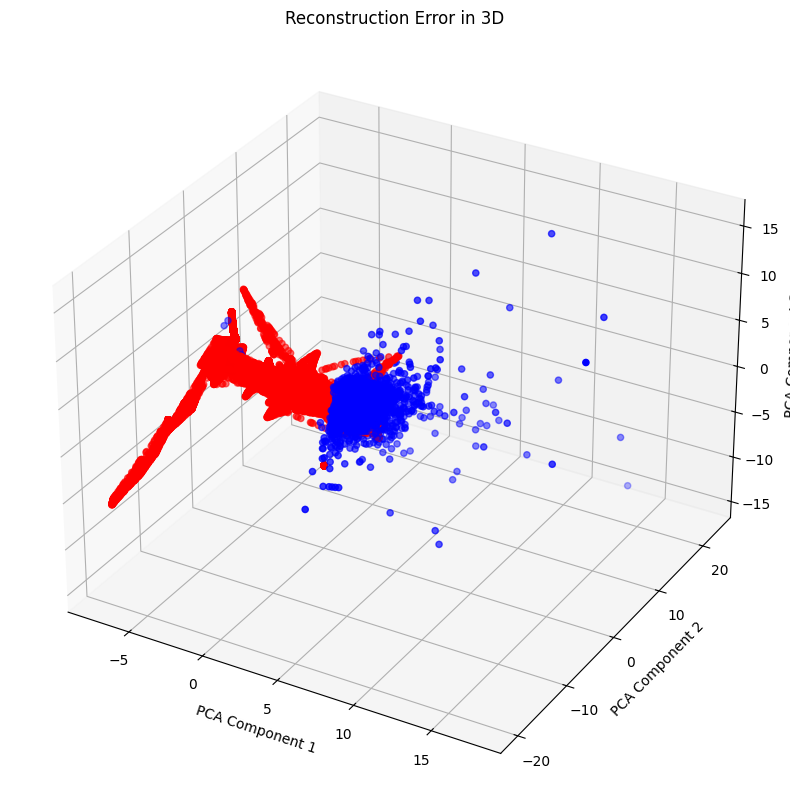

In [69]:
# 
pca = PCA(n_components=3)
X_test_reduced = pca.fit_transform(X_test)

# colores para los puntos, 'r' para anomalías y 'b' para normales
colors = ['r' if x == 1 else 'b' for x in y_test]

# 
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3D
scatter = ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2], 
                     c=colors, marker='o')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Reconstruction Error in 3D')

# Mostrar la gráfica
plt.show()


In [70]:
## Build the Autoencoder 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 128),  
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 128)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),  
            nn.ReLU(),
            nn.Linear(128, 29),  
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [42]:
 
# Training the autoencoder
num_epochs = 50
batch_size = 4

for epoch in range(num_epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = X_train_tensor[indices]
        
        # Forward pass
        outputs = autoencoder(batch_x)
        loss = criterion(outputs, batch_x)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/50], Loss: 0.8625
Epoch [2/50], Loss: 0.7878
Epoch [3/50], Loss: 0.8908
Epoch [4/50], Loss: 1.0522
Epoch [5/50], Loss: 1.0089
Epoch [6/50], Loss: 0.9936
Epoch [7/50], Loss: 0.9194
Epoch [8/50], Loss: 0.7522
Epoch [9/50], Loss: 0.9603
Epoch [10/50], Loss: 0.7368
Epoch [11/50], Loss: 0.9876
Epoch [12/50], Loss: 0.9617
Epoch [13/50], Loss: 0.6779
Epoch [14/50], Loss: 0.7936
Epoch [15/50], Loss: 0.7571
Epoch [16/50], Loss: 0.8203
Epoch [17/50], Loss: 0.7739
Epoch [18/50], Loss: 0.7233
Epoch [19/50], Loss: 0.6093
Epoch [20/50], Loss: 0.6240
Epoch [21/50], Loss: 0.8644
Epoch [22/50], Loss: 0.5804
Epoch [23/50], Loss: 1.1486
Epoch [24/50], Loss: 1.0061
Epoch [25/50], Loss: 0.8587
Epoch [26/50], Loss: 0.9208
Epoch [27/50], Loss: 0.7204
Epoch [28/50], Loss: 0.6305
Epoch [29/50], Loss: 0.7165
Epoch [30/50], Loss: 0.6765
Epoch [31/50], Loss: 0.6847
Epoch [32/50], Loss: 0.5267
Epoch [33/50], Loss: 0.4903
Epoch [34/50], Loss: 0.6175
Epoch [35/50], Loss: 0.9544
Epoch [36/50], Loss: 0.9124
E

In [43]:
# Calculate reconstruction error on the training set
with torch.no_grad():
    reconstructions = autoencoder(X_train_tensor)
    train_loss = criterion(reconstructions, X_train_tensor)
print(f'Training set loss: {train_loss.item():.4f}')

# Set the threshold as a multiple of the training set loss
threshold = train_loss.item() * 1.5
print(f'Set threshold: {threshold:.4f}')


Training set loss: 0.7495
Set threshold: 1.1243


In [44]:
# Detect anomalies on the test set
with torch.no_grad():
    reconstructions = autoencoder(X_test_tensor)
    test_loss = torch.mean((reconstructions - X_test_tensor) ** 2, dim=1)

anomalies = test_loss > threshold
anomaly_indices = np.where(anomalies.cpu().numpy())[0]

print(f'Number of anomalies detected: {len(anomaly_indices)}')


Number of anomalies detected: 16370


In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Create a list of predictions (1 for anomaly, 0 for normal)
y_pred = np.zeros_like(y_test)
y_pred[anomaly_indices] = 1

# Evaluate the system
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.8952
Recall: 0.2572
F1 Score: 0.3996


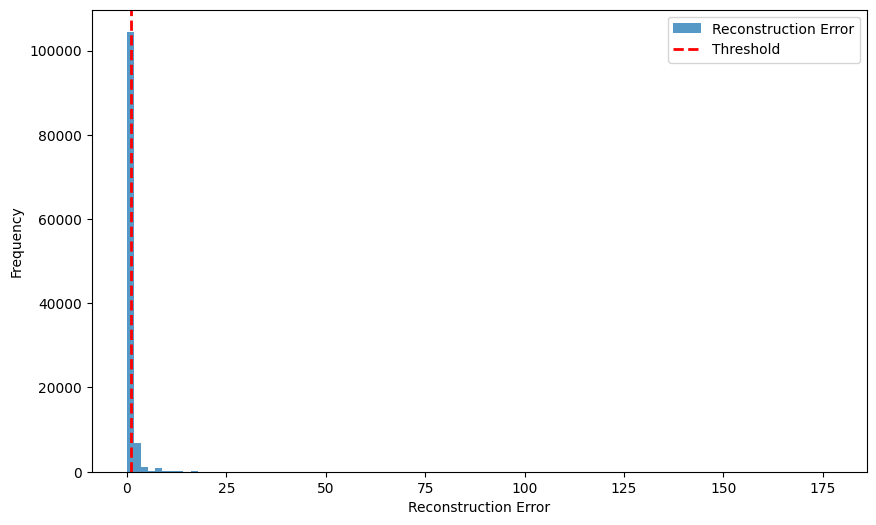

In [58]:
# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(test_loss.cpu().numpy(), bins=100, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


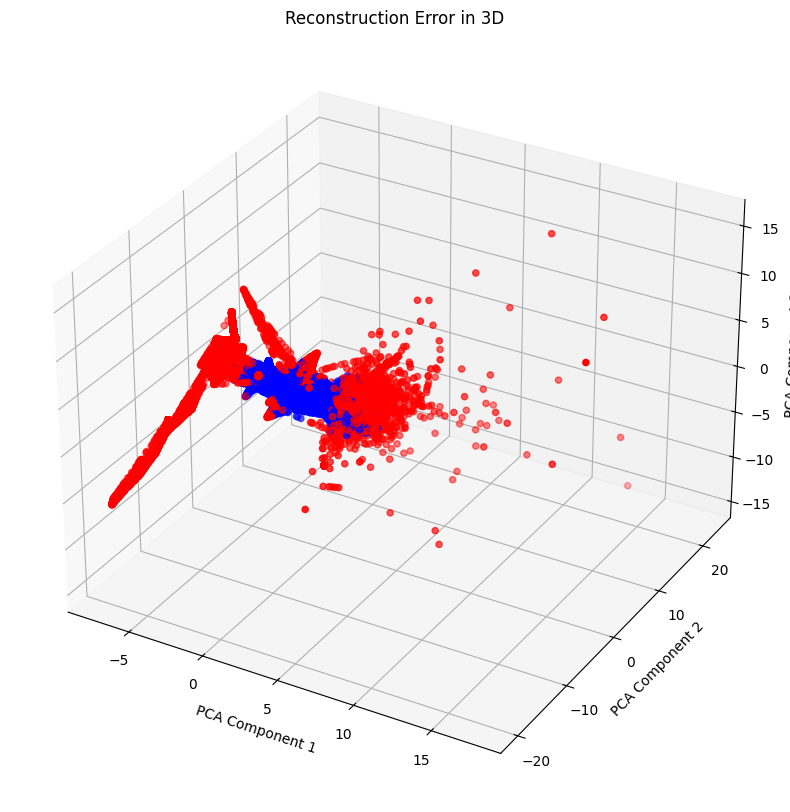

In [57]:
# 
pca = PCA(n_components=3)
X_test_reduced = pca.fit_transform(X_test)

# colores para los puntos, 'r' para anomalías y 'b' para normales
colors = ['r' if x else 'b' for x in anomalies.cpu().numpy()]

# 
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3D
scatter = ax.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], X_test_reduced[:, 2], 
                     c=colors, marker='o')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Reconstruction Error in 3D')

# Mostrar la gráfica
plt.show()
